"Run all" on this notebook to skip all analysis and generate all plots from the paper

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import richardsplot as rplot
import numpy as np
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
from astropy.stats import sigma_clip
from scipy.stats import norm

/Users/trevormccaffrey/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
def figsze(hscale, 
            vscale=0.618034,
            fig_width_pt = 504.0):
    """Get the fig_width_pt by inserting the textwidth into LaTeX document.
    hscale is fraction of text width you want.
    vscale is fraction of hscale (defaults to golden ratio)  
    """
   
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt*hscale   # width in inches
    fig_height = fig_width*vscale                   # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.5,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 16,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis
    "axes.formatter.limits":[-99,99],   # use sci notation if log10 of axis range is smaller than first or larger than second.
                                        # GTR: Actually *don't* -- should change the axis label instead.  E.g., "Flux Density (10^-17 ergs/s/cm^2)" 
                                        # This is a hack b/c there doesn't seem to be an rcParams version of
                                        # axes.ticklabel_format(style='plain')
    #"axes.formatter.style":"plain",    # Turn off multiplicative offsets (sci notation) to the axes [GTR: Doesn't work]
    "axes.formatter.useoffset":False,   # Turn off additive offsets to the axes
    "font.size": 16,
    "legend.fontsize": 12,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 16,              # Font size of numbers 
    "ytick.labelsize": 16,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    'xtick.major.width':1, 
    'xtick.minor.width':1, 
    'ytick.major.width':1, 
    'ytick.minor.width':1, 
    'xtick.major.size':10,             # size of tickmarks in points
    'xtick.minor.size':5, 
    'ytick.major.size':10, 
    'ytick.minor.size':5,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
    "figure.figsize": figsze(1,1),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_latex)

/Users/trevormccaffrey/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [4]:
#Equations

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on flux at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

def fluxdensity(nu1, nu2, L, alpha, z):
    #calculate flux density at nu2 based on luminosity at nu1
    L = 10.**L
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    S = L * (nu2/nu1)**alpha * (((1+z)**(1+alpha))/(4*np.pi*DL**2)) * 1e36
    return S #return flux density in microJy

def SFR_L14(L14):
    #Yun+2001 SFR relation based on 1.4GHz luminosity
    return 5.9e-22 * (10**L14)

def SFR_Mi(Mi):
    #Absolute magnitude SFR relation from Harris+2016
    return -29*Mi**2 - 1625*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328

In [5]:
radluminosity(6., 1.4, 1120, -0.0, .274)

23.31374142056426

In [6]:
figs = pd.read_csv("SpringFinalFigs_moreParams.csv")
z = figs[["redshift_1"]].values.flatten()
det = figs[['detection']].values.astype("int").flatten()
Sp3 = figs[['peak_flux']].values.flatten()
S3 = figs[['int_flux']].values.flatten()
L3 = radluminosity(3., 3., S3, -0.7, z)
ew_civ = figs[['ICA_CIV_EQW']].values.flatten()
voff_civ = figs[['ICA_CIV_BLUESHIFT']].values.flatten()
F = figs[['FIRST']].values.astype("int").flatten()
CIVdist = figs[["RM_DIST_SCALE"]].values.flatten()
L2500 = figs[["L_2500"]].values.flatten()

D = det+F
uni = (figs[["UNI_FLAG"]].values.flatten()==1)


col = ["red", "blue", "orange"]

Compute $L_\mathrm{Bol}$ for the sample with Krawczyk+2013

$$ log L_{bol} = (0.9869 \pm 0.0003) log (\nu_{2500Å} L_{2500Å}) + (1.051 \pm 0.014) $$

In [7]:
Lbol = 0.9869 * np.log10((3.e8/(2500*1e-10))*(10**L2500)) + 1.051
np.min(Lbol), np.max(Lbol), np.median(Lbol), Lbol

(46.12683501437415,
 46.81013703980207,
 46.335998469905576,
 array([46.69192641, 46.12683501, 46.22441101, 46.20950364, 46.14524565,
        46.61083402, 46.15383415, 46.170548  , 46.1600149 , 46.42382507,
        46.49772793, 46.321692  , 46.43156163, 46.34200265, 46.32999429,
        46.52751446, 46.26880653, 46.5551916 , 46.274922  , 46.24999556,
        46.38259668, 46.32756571, 46.35396573, 46.15024749, 46.24846328,
        46.41520249, 46.47703211, 46.35549757, 46.74465116, 46.81013704,
        46.37099056, 46.40934657, 46.25835479, 46.29387936, 46.25360495,
        46.37279272, 46.57886556, 46.2747294 , 46.43231543, 46.28495486,
        46.34259163, 46.38925437, 46.31890544, 46.14489998, 46.53231994,
        46.20329877, 46.19127406, 46.47229426, 46.19295903, 46.37833388]))

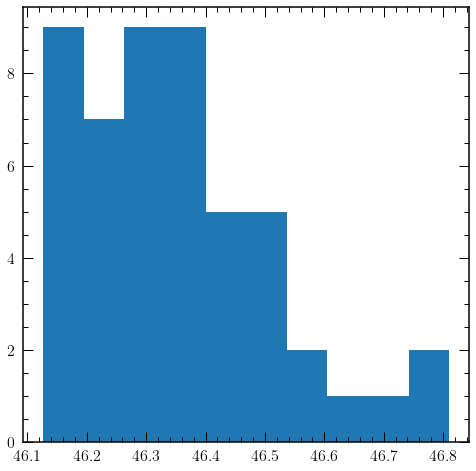

In [8]:
fig = plt.figure(figsize=(8,8))
plt.hist(Lbol)
plt.show()

# 1. Distributions of targets

The following figure plots the measured 3 GHz total flux densities from our sample.  The top axis shows the corresponding luminosity distribution assuming a uniform redshift $z=1.65$

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


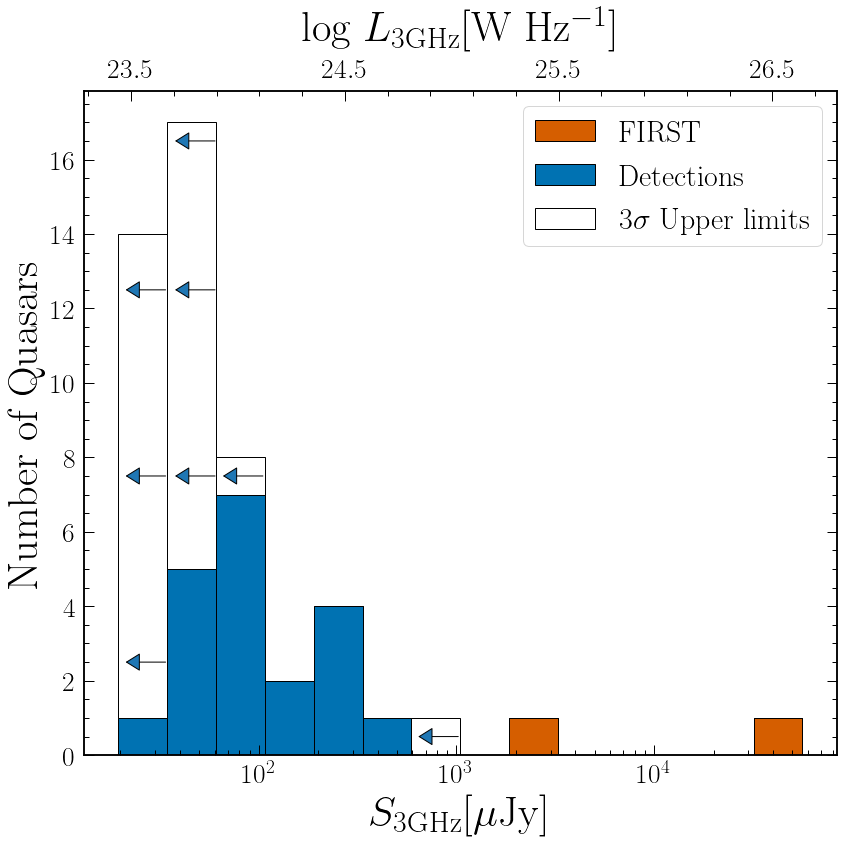

In [9]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111)

Lbins = np.linspace(min(L3), max(L3), 15)
Sbins = np.logspace(np.log10(min(S3)), np.log10(max(S3)), 15)


ax1.hist([S3[D==2], S3[D==1], S3[D==0]], histtype="barstacked", color=["#d55e00", "#0072b2", "w"],
          edgecolor="k", bins=Sbins, label=["FIRST", "Detections", "3$\sigma$ Upper limits"])


#Upper limit symbols
ax1.annotate('', xy=(10**1.54, 2.5), xytext=(-44, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.54, 7.5), xytext=(-44, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.54, 12.5), xytext=(-44, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**1.79, 7.5), xytext=(-44, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.79, 12.5), xytext=(-44, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.79, 16.5), xytext=(-44, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**2.032, 7.5), xytext=(-44, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**3.02, 0.5), xytext=(-44, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))

#ax1.set_xscale("log")
ax1.set_xlabel("$S_\mathrm{3GHz}[\\mu$Jy]", fontsize=42.5)
ax1.set_ylabel("Number of Quasars", fontsize=42.5)
ax1.legend(loc="best", prop={"size": 30})
ax1.set_xscale("log")
ax1.tick_params(axis='both', which='major', labelsize=27.5)

#Manually add luminosity axis
ax2 = ax1.twiny()
ax2.set_xlim(23.28,26.8)
ax2.set_xticks([23.5, 24.5, 25.5, 26.5])
ax2.set_xlabel("log $L_\mathrm{3GHz} [\mathrm{W\ Hz^{-1}}]$", fontsize=42.5)
ax2.xaxis.labelpad = 17.5
ax2.tick_params(axis='both', which='major', labelsize=27.5)
plt.tight_layout()
plt.savefig("PaperPlots/flux_distribution_wlum.pdf")
plt.show()

^I added the secondary luminosity axis manually since making it a function of the flux x-axis was getting really annoying (IDK why, maybe since it's on a log scale?).  In any case, it's still accurate

----

# 2. CIV Space

In [10]:
#Load in data from RM sample
df2 = pd.read_csv('RM_CIV_Ordering/SDSSRMMedianCIVParams_wCIVDist.csv')
control_eqw = df2[["Median_CIV_EQW"]].values.flatten()
control_voff = df2[["Median_CIV_Blueshift"]].values.flatten()

#Unscaled CIV params from original file
Miz2 = figs[['MI_Z2']].values.flatten()
vla_eqw = figs[['ICA_CIV_EQW']].values.flatten()
vla_voff = figs[['ICA_CIV_BLUESHIFT']].values.flatten()

L14 = radluminosity(1.4, 3., S3, -0.7, z)

#Skip analysis to make main plot (this is all scaled data)
bestfit_raw = np.load("RM_CIV_Ordering/CIV_PlotArrays/RM_CIV_bestFitLine_noscale.npy")
bestfit_indices = figs[["CIVBestfit_Index"]].values.flatten().astype("int")
bestfit = np.load("RM_CIV_Ordering/CIV_PlotArrays/RM_CIV_bestFitLine_scale.npy")
control = np.load("RM_CIV_Ordering/CIV_PlotArrays/RM_CIVParams_scale.npy")
vla_civ = np.load("RM_CIV_Ordering/CIV_PlotArrays/VLA_CIVParams_scale.npy")
vlaXY = np.load("RM_CIV_Ordering/CIV_PlotArrays/VLA_CIV_fitXYCoords_scale.npy")

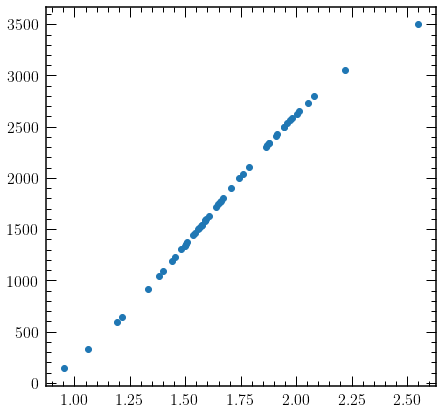

In [11]:
#Star formation rates from Harris/Yun
SFR_Mag = SFR_Mi(Miz2)
SFR_eq = SFR_eqw(ew_civ)
avgSFR = (SFR_Mag+SFR_eq)/2.
SFRL14 = SFR_L14(L14)

#The standard size scaling for these plots -
#Determination of this scaling happened in Trevor's version of "CIV_plot_GTR_fixed.ipynb"
#sent to GTR and AEK through the e-mail thread "VLA Paper" on 9/3/2020 at 5:05 PM

A = 100. #lower asymptote
K = 2800. #upper asymptote
B = 4.3 #growth rate
nu = 1.8 #affects where the max growth occurs
Q = 5. #related to intitial condition

logistic_harris = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(avgSFR)))))**(1/nu)) for i in np.log10(avgSFR)])
logistic_yun = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(avgSFR)))))**(1/nu)) for i in np.log10(SFRL14)])

#For the ratio plot the scaling is different
ratio = logistic_yun/logistic_harris

A = -800. #lower asymptote
K = 4000. #upper asymptote
B = 2.3 #growth rate
nu = 1.1 #affects where the max growth occurs
Q = 5. #related to intitial condition

logistic_ratio = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(ratio))))**(1/nu)) for i in ratio])
plt.scatter(ratio, logistic_ratio)

In [12]:
min(logistic_ratio), max(logistic_ratio)

(141.52316499428218, 3504.8491598694554)

In [13]:
#Get the size for if Harris Radio == True Radio
rateq1 = A + (K-A)/((1+Q*np.e**(-B*(1.-min(ratio))))**(1/nu))
rateq1

220.78197325519204

## 2a) Same size, project points onto best fit line

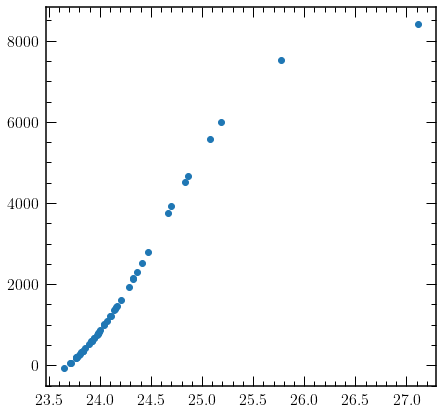

(347.15817580469684, 8416.972252002488)

In [14]:
A = -1100. #lower asymptote
K = 8500. #upper asymptote
B = 1.9 #growth rate
nu = 0.8 #affects where the max growth occurs
Q = 5. #related to intitial condition

logistic_radio = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(L14))))**(1/nu)) for i in L14])

plt.scatter(L14, logistic_radio)
plt.show()

min(logistic_radio[D==1]), max(logistic_radio)

GTR says in an email to Amy and me on 11/20/20:

One comment from the Cambridge folks about Figures 5 vs. 6 leads to one
suggestion about Figures 5 (CIV w/ projections) and 6 (CIV w/ insets).

Can we take the point that is closest to being predicted accurately in
Figure 6b, then make sure that point has a similar scaling in both
Figures 5 and 6a?


A: Sure; actually, the most accurately predicted point is the smallest blue point in the lower left of the CIV plots (1200+0005).  Fix the by just adding a constant to the "logistic_radio" variable so that their size distributions are aligned.

In [15]:
#Find object closest to SFR_obs = SFR_pred
bulk_ind = np.argmin((((SFRL14/avgSFR)-1.)**2)[det==0])
print(np.array([figs['name'], ((SFRL14/avgSFR)-1.), det, logistic_radio, logistic_harris]).T[bulk_ind])

['SDSSJ120015.35+000553.1' -0.24185144602344888 1 347.15817580469684
 2584.787717456241]


In [16]:
logistic_harris[bulk_ind], logistic_radio[bulk_ind], logistic_ratio[bulk_ind]

(2584.787717456241, 347.15817580469684, 141.52316499428218)

vv Do this so that the most accurately predicted point has the same size in the observed scale and Harris-predicted scale

In [17]:
abs(logistic_harris[bulk_ind] - logistic_radio[bulk_ind])

2237.629541651544

In [18]:
scaleup = 0.30
logistic_radio += scaleup*abs(logistic_harris[bulk_ind] - logistic_radio[bulk_ind])
logistic_harris -= (1-scaleup)*abs(logistic_harris[bulk_ind] - logistic_radio[bulk_ind])

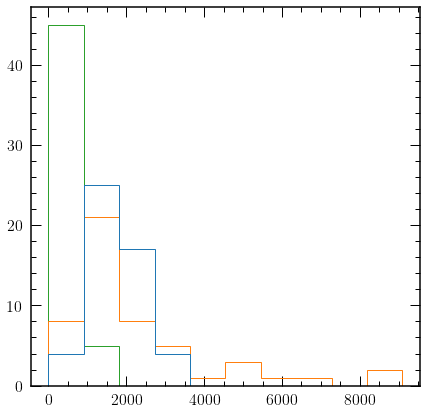

In [19]:
_ = plt.hist([logistic_ratio, logistic_radio, logistic_harris], histtype="step")

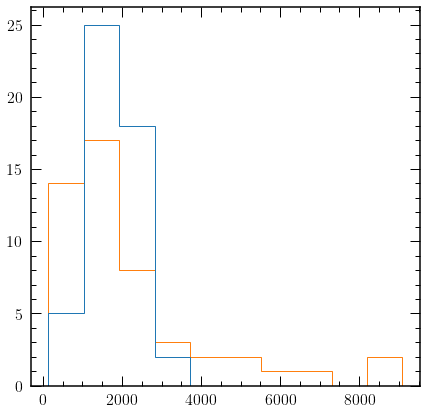

In [20]:
_ = plt.hist([logistic_ratio, logistic_radio], histtype="step")

logistic_radio = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(L14))))**(1/nu)) for i in L14])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
logistic_radio_scale = scaler.fit_transform(logistic_radio[:,None])

logistic_radio_scale += abs(min(logistic_radio_scale))
logistic_radio_scale /= np.median(logistic_radio_scale)
logistic_radio_scale = logistic_radio_scale.flatten()

logistic_radio = (np.median(logistic_harris)*logistic_radio_scale + min(logistic_harris)).flatten()

In [21]:
logistic_radio.shape

(50,)

logistic_yun -= 1000.
np.min(logistic_yun)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


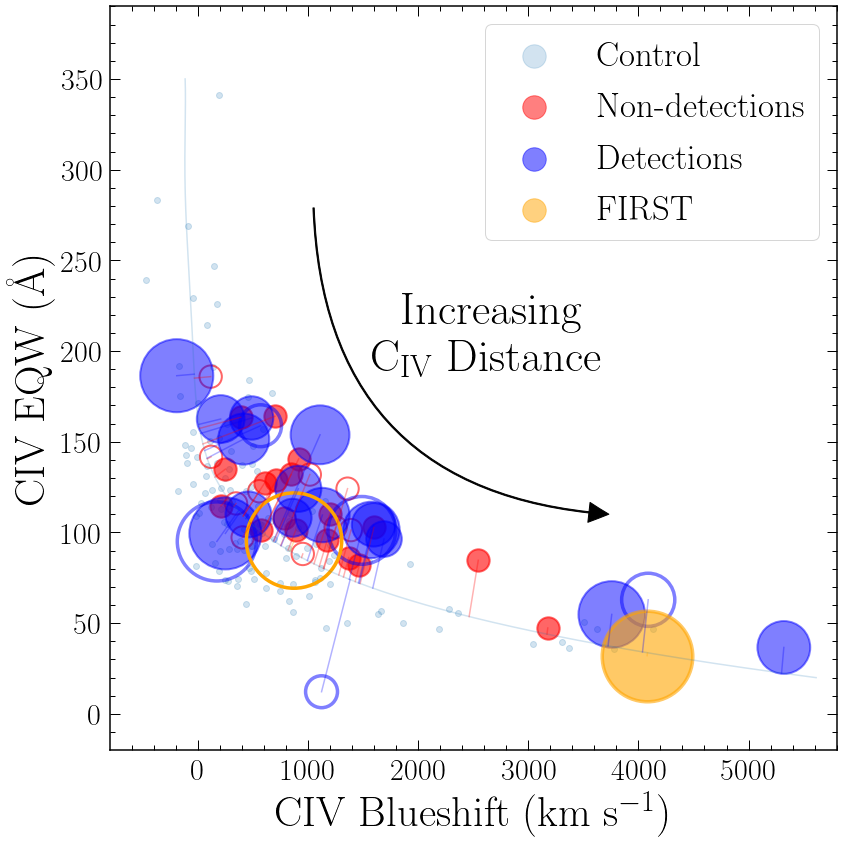

In [22]:
import matplotlib.patches as patches

plt.figure(figsize=(12,12))

plt.plot(bestfit_raw[:,0], bestfit_raw[:,1], alpha=0.2)
plt.scatter(control_voff, control_eqw, alpha=0.2)


plt.scatter(voff_civ[(D==0)&(uni)], ew_civ[(D==0)&(uni)], s=500, facecolor="red", 
            alpha=0.6, edgecolor="red", linewidth=2)
plt.scatter(voff_civ[(D==0)&(~uni)], ew_civ[(D==0)&(~uni)], s=500, facecolor="None", 
            alpha=0.6, edgecolor="red", linewidth=2)

plt.scatter(voff_civ[(D==1)&(uni)], ew_civ[(D==1)&(uni)], s=logistic_radio[(D==1)&(uni)],
            facecolor="blue", edgecolor="blue", alpha=0.5, linewidth=2)
plt.scatter(voff_civ[(D==1)&(~uni)], ew_civ[(D==1)&(~uni)], s=logistic_radio[(D==1)&(~uni)],
            facecolor="None", edgecolor="blue", alpha=0.5, linewidth=3.5)

plt.scatter(voff_civ[(D==2)&(uni)], ew_civ[(D==2)&(uni)], s=logistic_radio[(D==2)&(uni)],
            facecolor="orange", edgecolor="orange", alpha=0.6, linewidth=3.5)
plt.scatter(voff_civ[(D==2)&(~uni)], ew_civ[(D==2)&(~uni)], s=logistic_radio[(D==2)&(~uni)],
            facecolor="None", edgecolor="orange", alpha=1.0, linewidth=3.5)

for i in range(len(vla_civ)):
    plt.plot([bestfit_raw[bestfit_indices[i],0], voff_civ[i]], 
             [bestfit_raw[bestfit_indices[i],1], ew_civ[i]], color=col[int(D[i])], alpha=0.3)
    

#Faux points so they're the same size in the legend
plt.scatter(5000, 5000, s=550, color=colors[0], alpha=0.2, label="Control")
plt.scatter(5000, 5000, s=550, color="red", alpha=0.5, label="Non-detections")
plt.scatter(5000, 5000, s=550, color="blue", alpha=0.5, label="Detections")
plt.scatter(5000, 5000, s=550, color="orange", alpha=0.5, label="FIRST")


#10/31/20: Add curved arrow to indicate increasing CIV distance
style = "Simple, tail_width=1.25, head_width=20, head_length=20"
kw = dict(arrowstyle=style, color="k")
#a1 = patches.FancyArrowPatch((950, 295), (4250, 105),
#                             connectionstyle="arc3,rad=.4", **kw)
a1 = patches.FancyArrowPatch((1050, 280), (3750, 110),
                             connectionstyle="arc3,rad=.45", **kw)
plt.gca().add_patch(a1)
plt.text(x=1850,y=215,s="Increasing", fontsize=45, weight='extra bold')
plt.text(x=1585,y=190,s="C$_\mathrm{IV}$ Distance", fontsize=45)

plt.xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=42.5)
plt.ylabel("CIV EQW (Å)", fontsize=42.5)
plt.legend(loc="best", prop={'size': 35})
plt.xlim(-800,5800)
plt.ylim(-20,390)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.savefig("PaperPlots/radioTargets_1DCIVSpace_wprojection.pdf")
plt.show()

## 2b) Unscaled data; scale the point sizes on the average SFR predicted from the optical luminosity / EQW relations from Harris+2016

In [23]:
logGTR = radluminosity(1.4, 3., S3, -0.7, z)

#Use Yun+2001 to invert these SFRs to L1.4GHz
L14_eqw = 1.7e21*SFR_eqw(vla_eqw)
L14_Mi = 1.7e21*SFR_Mi(Miz2)
L14_gtr = 10.**logGTR
bins1 = np.logspace(np.log10(min(min(L14_eqw[L14_eqw>0.]), min(L14_Mi[L14_Mi>0.]))), np.log10(max(L14_gtr)), 35)

In [24]:
print(logistic_harris[logistic_harris<0])

[]


/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


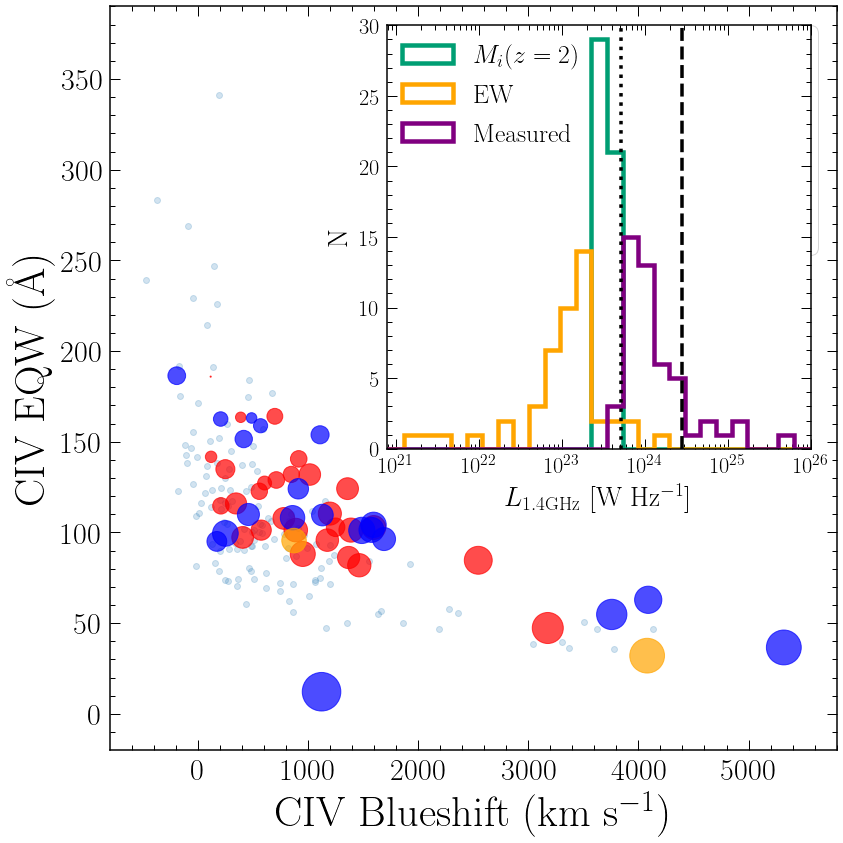

In [25]:
fig, ax1 = plt.subplots(figsize=(12,12))

ax1.scatter(control_voff, control_eqw, alpha=0.2)

ax1.scatter(voff_civ[D==0], ew_civ[D==0], s=logistic_harris[D==0], color="red", alpha=0.7)
ax1.scatter(voff_civ[D==1], ew_civ[D==1], s=logistic_harris[D==1], color="blue", alpha=0.7)
ax1.scatter(voff_civ[D==2], ew_civ[D==2], s=logistic_harris[D==2], color="orange", alpha=0.7)

#Faux points so they're the same size in the legend
ax1.scatter(5000, 5000, s=550, color=colors[0], alpha=0.2, label="Control")
ax1.scatter(5000, 5000, s=550, color="red", alpha=0.7, label="Non-detections")
ax1.scatter(5000, 5000, s=550, color="blue", alpha=0.7, label="Detections")
ax1.scatter(5000, 5000, s=550, color="orange", alpha=0.7, label="FIRST")

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.46, 0.468, 0.49, 0.49]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.hist([L14_gtr, L14_eqw, L14_Mi], histtype="step", bins=bins1, color=["purple", "#ffa500", "#009e73"],
          label=["Measured", "EW", "$M_i(z=2)$"],
          linewidth=4.5)

ax2.plot([10**24.45,10**24.45],[0,38],"--k",linewidth=3.5) #label="AGN dominate"
ax2.plot([10**23.71,10**23.71],[0,38],":k",linewidth=3.5)  #label="Intended Flux Den. Limit"
ax2.set_ylim([0,30])
ax2.set_xlim([10.**20.9,10.**26.])
ax2.set_xscale("log")
ax2.set_xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=27.5)
ax2.set_ylabel("N",fontsize=27.5)
ax2.legend(bbox_to_anchor=(0.51,0.66), frameon=False, prop={"size":25.75})
ax2.tick_params(axis='both', which='major', labelsize=22.5)


ax1.set_xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=42.5)
ax1.set_ylabel("CIV EQW (Å)", fontsize=42.5)
ax1.set_xlim(-800,5800)
ax1.set_ylim(-20,390)
#ax1.legend(loc="best", bbox_to_anchor=(0.64,0.21), prop={'size': 23.5})
ax1.legend(loc="best", prop={'size': 37.5})
ax1.tick_params(axis='both', which='major', labelsize=30)
#ax1.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()
plt.savefig("PaperPlots/CIVPlot_sizeHarris_SFRinset.pdf")
#plt.savefig("PaperPlots/CIVPlot_sizeHarris.pdf")
plt.show()

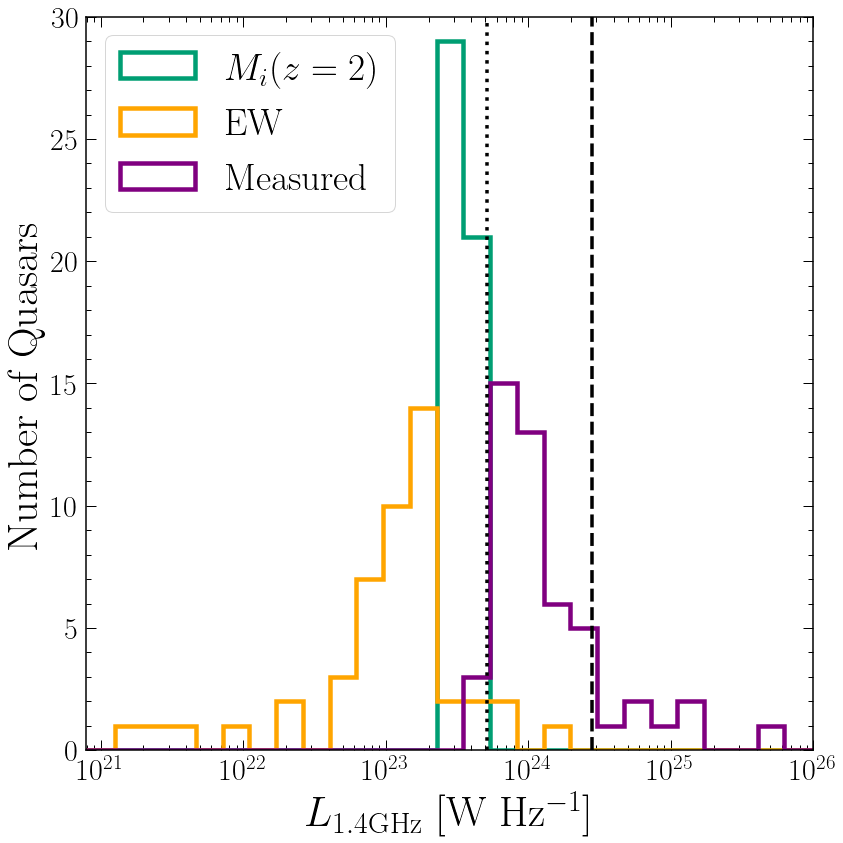

In [26]:
#Plot the inset on its own
fig = plt.figure(figsize=(12,12))

plt.hist([L14_gtr, L14_eqw, L14_Mi], histtype="step", bins=bins1, color=["purple", "#ffa500", "#009e73"],
          label=["Measured", "EW", "$M_i(z=2)$"],
          linewidth=4.5)

plt.plot([10**24.45,10**24.45],[0,38],"--k",linewidth=3.5) #label="AGN dominate"
plt.plot([10**23.71,10**23.71],[0,38],":k",linewidth=3.5)  #label="Intended Flux Den. Limit"
plt.ylim([0,30])
plt.xlim([10.**20.9,10.**26.])
plt.xscale("log")
plt.xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=42.5)
plt.ylabel("Number of Quasars",fontsize=42.5)
plt.legend(loc="upper left", frameon=True, prop={"size":37.5})
plt.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
plt.savefig("PaperPlots/CIVPlot_SFRhisto_inset.pdf")

## 2c) Unscaled data; scale the point sizes on the SFR predicted from the Yun radio luminosity relation

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


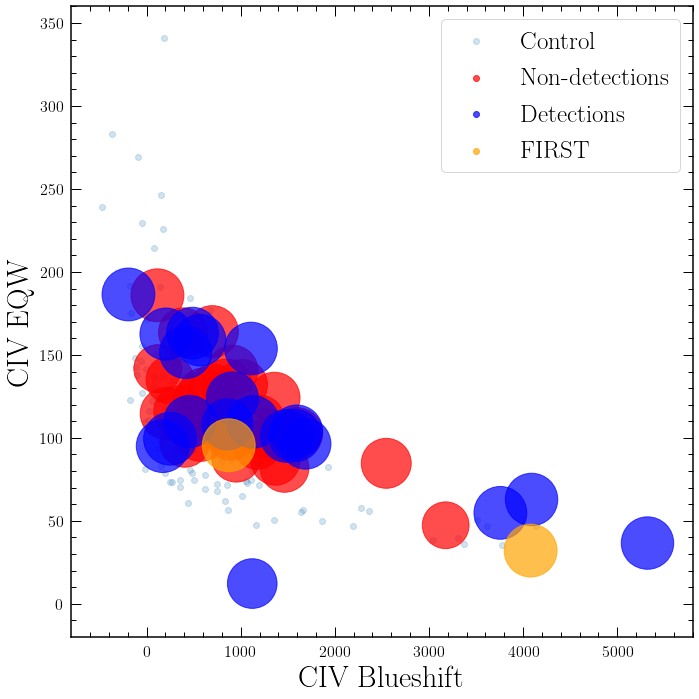

In [27]:
plt.figure(figsize=(10,10))

plt.scatter(control_voff, control_eqw, alpha=0.2, label="Control")

plt.scatter(voff_civ[D==0], ew_civ[D==0], s=logistic_yun[D==0], color="red", alpha=0.7)
plt.scatter(voff_civ[D==1], ew_civ[D==1], s=logistic_yun[D==1], color="blue", alpha=0.7)
plt.scatter(voff_civ[D==2], ew_civ[D==2], s=logistic_yun[D==2], color="orange", alpha=0.7)

#Faux points so they're the same size in the legend
plt.scatter(5000, 5000, color="red", alpha=0.7, label="Non-detections")
plt.scatter(5000, 5000, color="blue", alpha=0.7, label="Detections")
plt.scatter(5000, 5000, color="orange", alpha=0.7, label="FIRST")

plt.xlabel("CIV Blueshift", fontsize=30)
plt.ylabel("CIV EQW", fontsize=30)
plt.xlim(-800,5800)
plt.ylim(-20,360)
plt.legend(loc="best", prop={'size': 25})
plt.tight_layout()
#plt.savefig("PaperPlots/CIVPlot_sizeYun.pdf")
plt.show()

## 2d) Now scale the sizes of points based on the ratio between the Harris and Yun relations; thus bigger points represent more excess radio emission than that predicted based on star formation from Harris

In [28]:
(logistic_ratio[D==1]<=rateq1).sum()

1

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


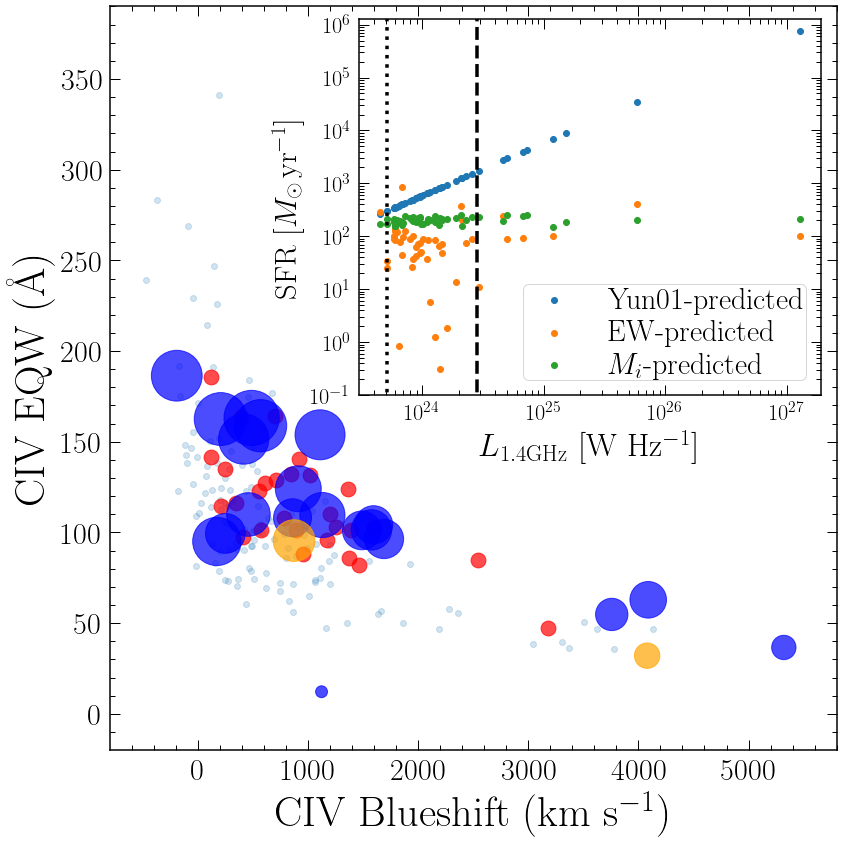

In [29]:
fig, ax1 = plt.subplots(figsize=(12,12))

ax1.scatter(control_voff, control_eqw, alpha=0.2)

ax1.scatter(voff_civ[D==0], ew_civ[D==0], s=rateq1, color="red", alpha=0.7)
ax1.scatter(voff_civ[D==1], ew_civ[D==1], s=logistic_ratio[D==1], color="blue", alpha=0.7)
ax1.scatter(voff_civ[D==2], ew_civ[D==2], s=logistic_ratio[D==2], color="orange", alpha=0.7)

#Faux points so they're the same size in the legend
ax1.scatter(5000, 5000, s=550, color=colors[0], alpha=0.2, label="Control")
ax1.scatter(5000, 5000, s=550, color="red", alpha=0.7, label="Non-detections")
ax1.scatter(5000, 5000, s=550, color="blue", alpha=0.7, label="Detections")
ax1.scatter(5000, 5000, s=550, color="orange", alpha=0.7, label="FIRST")

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.427, 0.53, 0.535, 0.435]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.scatter(L14_gtr, SFR_L14(logGTR), label="Yun01-predicted")
ax2.scatter(L14_gtr, SFR_eqw(vla_eqw), label="EW-predicted")
ax2.scatter(L14_gtr, SFR_Mi(Miz2), label="$M_{i}$-predicted")
ax2.plot([10**24.45,10**24.45],[10**-2,10**7],"--k",linewidth=3.5)#,label="AGN dominate")
ax2.plot([10**23.71,10**23.71],[10**-2,10**7],":k",linewidth=3.5)#.,label="Intended Flux Den. Limit")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylim(0.1, 10**6.1)
#ax2.set_xlim(10**23.55, 10**27.55)
ax2.set_xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=32.5)
ax2.set_ylabel("SFR [$M_{\odot}$\,$\mathrm{ yr}^{-1}$]",fontsize=30.5)
ax2.legend(loc="best", prop={"size":30}, borderpad=0.05, labelspacing=0.11)
ax2.tick_params(axis='both', which='major', labelsize=22.5)

ax1.set_xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=42.5)
ax1.set_ylabel("CIV EQW (Å)", fontsize=42.5)
ax1.set_xlim(-800,5800)
ax1.set_ylim(-20,390)
#ax1.legend(bbox_to_anchor=(0.62,0.21), prop={'size': 25.5})
ax1.legend(loc="best", prop={'size': 37.5})
ax1.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.savefig("PaperPlots/CIVPlot_sizeRatio_SFRwlinesInset_NDnotscaled.pdf")
#plt.savefig("PaperPlots/CIVPlot_sizeRatio_NDnotscaled.pdf")
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


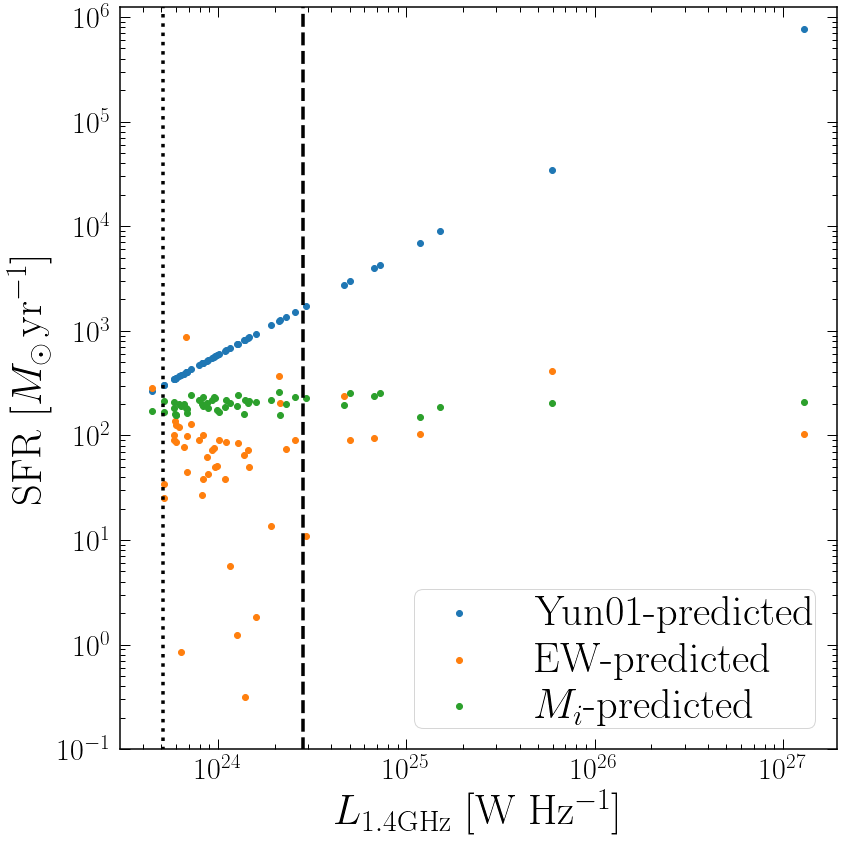

In [30]:
fig = plt.figure(figsize=(12,12))
plt.scatter(L14_gtr, SFR_L14(logGTR), label="Yun01-predicted")
plt.scatter(L14_gtr, SFR_eqw(vla_eqw), label="EW-predicted")
plt.scatter(L14_gtr, SFR_Mi(Miz2), label="$M_{i}$-predicted")
plt.plot([10**24.45,10**24.45],[10**-2,10**7],"--k",linewidth=3.5)#,label="AGN dominate")
plt.plot([10**23.71,10**23.71],[10**-2,10**7],":k",linewidth=3.5)#,label="Intended Flux Den. Limit")
plt.xscale("log")
plt.yscale("log")
plt.ylim(0.1, 10**6.1)
#plt.xlim(10**23.55, 10**27.55)
plt.xlabel("$L_\mathrm{1.4GHz}$ [W Hz$^{-1}$]",fontsize=42.5)
plt.ylabel("SFR [$M_{\odot}$\,$\mathrm{ yr}^{-1}$]",fontsize=42.5)
plt.legend(loc="best", prop={"size":42.5}, borderpad=0.05, labelspacing=0.11)
plt.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
plt.savefig("PaperPlots/CIVPlot_SFRwlinesInset.pdf")

---

# 3. Forced Photometry

In [31]:
#TVM added 10/31/2020 - the Shen objects are sorted same
#as the forced photometry objects, so just apply this mask to 
#z_nvss and fnvss below to limit analysis to 8403 color-selected objects
shen = pd.read_csv("PGv2_DR7_data/grdr7_Shen2011_targ_uni.csv")
COL=(shen["COL_FLAG"]==1)
COL.sum()

8403

In [32]:
z_nvss = pd.read_csv("forced_photometry.csv")[["REDSHIFT"]].values.flatten()[COL]
fnvss = 1000.*(pd.read_csv("forced_photometry.csv")[["Flux Density (Jy/b)"]].values.flatten()[COL]) #values in Jy - want mJy
fnvss_clip = sigma_clip(fnvss,sigma_lower=3,sigma_upper=2.5,maxiters=10,masked=False)

logGTR = radluminosity(1.4, 3., S3, -0.7, z)

## 3a) Histogram of all NVSS peak flux densities measured at the optical location of all 8653 color-selected QSOs from our parent sample with the scaled up PDF overplotted (the PDF fit is only performed on the clipped data

Fit Results:
Mean   = 0.0908 mJy/b
Median = 0.0900 mJy/b
Std    = 0.4859 mJy/b


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


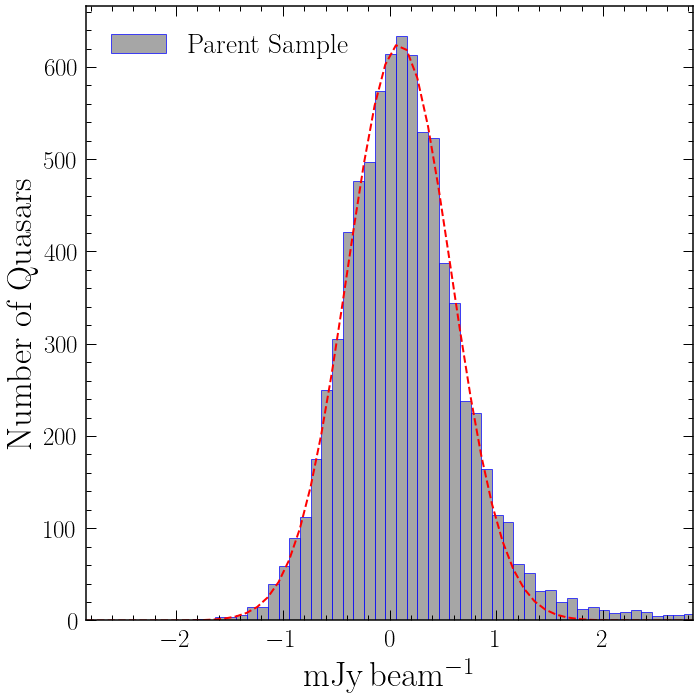

In [33]:
#Now do with clipped data
pf = 1e-3*S3 #convert GTR flux from µJy to mJy

# best fit of (clipped) data
# This gives the true median and sigma
(mu, sigma) = norm.fit(fnvss_clip)
median = np.median(fnvss_clip)

#Use the bins covering the full distribution
bins=np.arange(min(fnvss), max(fnvss), .1)

fig,ax = plt.subplots(1,1,figsize=(10,10))

#Plot fnvss histogram
plt.hist(fnvss,bins=bins,color='grey',edgecolor='b',alpha=0.7,label="Parent Sample")

#PDF of the clipped distribution
y = norm.pdf(bins, mu, sigma)
y_true = (y*len(fnvss_clip)*0.1) #get rid of normalization - 0.1 is bin width
plt.plot(bins, y_true, 'r--', linewidth=2)

plt.xlim(min(fnvss), abs(min(fnvss)))
plt.xlabel("mJy\,beam$^{-1}$", fontsize=35)
plt.ylabel("Number of Quasars", fontsize=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.legend(loc="upper left", prop={"size": 27.5}, frameon=False)

print("Fit Results:")
print("Mean   = %.4f mJy/b" % (mu))
print("Median = %.4f mJy/b" % (median))
print("Std    = %.4f mJy/b" % (sigma))

plt.tight_layout()
plt.savefig("PaperPlots/nvssForcedphotometry_unscaled.pdf")
plt.show()

## 3b) GTR version: convert clipped positive flux densities to luminosity and illustrate some characteristic points on the distribution

In [34]:
Lmed = radluminosity(1.4, 1.4, median*1000, -0.7, 1.84)
width=radluminosity(1.4, 1.4, (median+2*sigma)*1000, -0.7, 1.84)-radluminosity(1.4, 1.4, median*1000, -0.7, 1.84)
width

1.0717745260750462

1463


/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


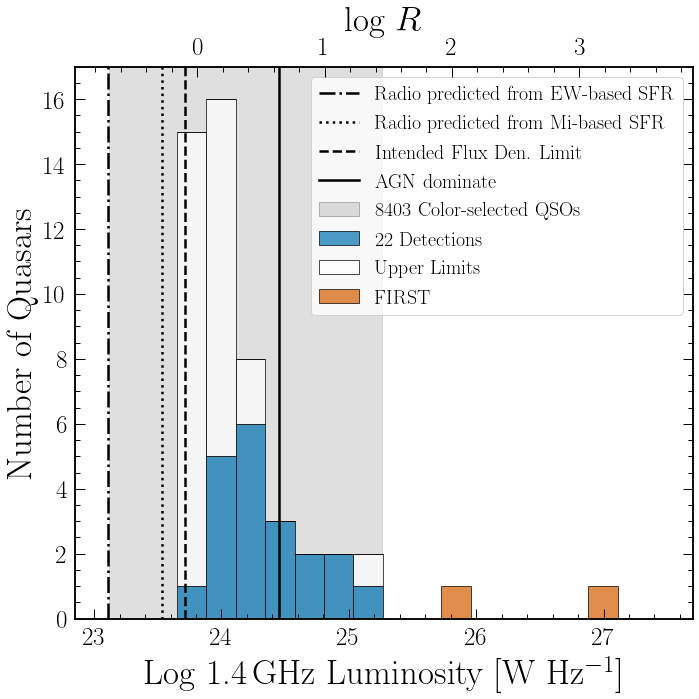

In [35]:
import matplotlib.patches as patches

#GTR version, just compare to positive detections and z<1.75
#Don't really need the gaussian fit.

Lnvss = radluminosity(1.4, 1.4, 1000.*fnvss[(fnvss>0.)&(z_nvss<1.75)], -0.7, z_nvss[(fnvss>0.)&(z_nvss<1.75)])
Lnvssbins=np.arange(min(Lnvss), max(Lnvss), .1)
print(len(Lnvss))

fig,ax1 = plt.subplots(1,1,figsize=(10,10))

#Change 10/31/2020: Amy and Gordon suggest to plot the NVSS
#data as just a shaded region, as not plotting the non-detections
#is making the distribution look much more right-shifted than it should
rect = patches.Rectangle((Lmed-width,0),2*width,38,linewidth=1,edgecolor='grey',facecolor='grey',alpha=0.25)
ax1.add_patch(rect)
#ax1.plot([Lmed,Lmed],[0,38], "#00ff00", linewidth=2.5, label="8403 Color-selected Objects")
ax1.hist(Lnvss+100, color="grey", edgecolor="k", bins=Lnvssbins, density=True, alpha=0.25, label="8403 Color-selected QSOs")


#Plot GTR data
ax1.hist([logGTR[D==1], logGTR[D==0], logGTR[D==2]], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
          alpha=0.7, edgecolor="k", bins=15, label=["22 Detections", "Upper Limits", "FIRST"])

#plt.annotate(s="$\mu$=24.81", xy=(25.6,1.3), size=45, color="red")
#plt.annotate(s="$\sigma$=0.54", xy=(25.6,1.1), size=45, color="red")

ax1.plot([23.11,23.11],[0,38],"-.k",linewidth=2.5,label="Radio predicted from EW-based SFR")
ax1.plot([23.535,23.535],[0,38],":k",linewidth=2.5,label="Radio predicted from Mi-based SFR")
ax1.plot([23.71,23.71],[0,38],"--k",linewidth=2.5,label="Intended Flux Den. Limit")
ax1.plot([24.45,24.45],[0,38],"-k",linewidth=2.5,label="AGN dominate")


ax1.set_xlim(22.85, 27.7)
ax1.set_ylim(0,17)
ax1.set_xlabel("Log 1.4\,GHz Luminosity [W Hz$^{-1}$]", fontsize=35)
ax1.set_ylabel("Number of Quasars", fontsize=35)
ax1.tick_params(axis='both', which='major', labelsize=25)
ax1.legend(loc="upper right", prop={"size":20})


#Manually add log R axis
ax2 = ax1.twiny()
lolim, hilim = ax1.get_xlim() #The x limits in luminosity
#Median of L2500 in our sample is 10^23.81
ax2.set_xlim(lolim-23.81, hilim-23.81)
ax2.set_xticks([0.0, 1.0, 2.0, 3.0])
ax2.set_xlabel("log $R$", fontsize=35)
ax2.tick_params(axis='both', which='major', labelsize=25)

plt.tight_layout()
#plt.savefig("PaperPlots/nvssForcedPhotometry_GTRoverplotted_wlines.pdf")
plt.show()

In [36]:
ax1.get_xlim()

(22.85, 27.7)

---

# 4. Tying in optical data

We define $R$ as being the ratio between the measured radio flux density (3 GHz) and that measured in the optical (2500 Å):

$$ R = \frac{S_\mathrm{3GHz}}{S_{2500Å}} $$

In [37]:
#Eq 4 from QLF paper Richards+2006; subtract 7 to convert erg/s to Watts
d = 3.08e19 # 10pc in cm
logL2500 = -0.4 * (Miz2 + 48.6 + 2.5*np.log10(1.+2.)) + np.log10(4.*np.pi*d**2.) - 7.

R = (10.**L3)/(10.**logL2500)
logR = np.log10(R)

In [38]:
#Optical data
z_hiz0 = shen[["REDSHIFT"]].values.flatten()
z_hiz = shen[["REDSHIFT"]].values.flatten()[(z_hiz0<1.75)]
Miz2_hiz = shen[["MI_Z2"]].values.flatten()[(z_hiz0<1.75)]
L2500_hiz = -0.4 * (Miz2_hiz + 48.6 + 2.5*np.log10(1.+2.)) + np.log10(4.*np.pi*d**2.) - 7.
#Radio data derived from forced photometry
#AGNmask=0.5: above AGN-dom, below jet-dom
#AGNmask=1.0: above jet-dom
AGNmask = shen[["AGNmask_fp_trevor"]].values.flatten()[(z_hiz0<1.75)]
L14_hiz = shen[["L14_fp_trevor"]].values.flatten()[(z_hiz0<1.75)]

In [39]:
condon = pd.read_csv("CONDON_1087lowz.csv")

over = (condon[["FLUX(Jy/b)"]].values.flatten()>0)
cS = condon[["FLUX(Jy/b)"]].values.flatten()[over]*1.e6
cz = condon[["REDSHIFT"]].values.flatten()[over]
cM = condon[["MI_Z2"]].values.flatten()[over]
cLopt = -0.4 * (cM + 48.6 + 2.5*np.log10(1.+2)) + np.log10(4.*np.pi*d**2) - 7.
cLrad = radluminosity(1.4, 6., cS, -0.7, cz)
cLrad.shape, cLopt.shape

((807,), (807,))

Note: We are limited to 807/1313 of the Condon+2013 QSOs in this figure

In [40]:
kell = pd.read_csv("Kellermann_MIZ2.csv")
z_kell    = kell[["REDSHIFT"]].values.flatten()
Miz2_kell = kell[["MI_Z2"]].values.flatten()
L2500_kell= -0.4 * (Miz2_kell + 48.6 + 2.5*np.log10(1.+2.)) + np.log10(4.*np.pi*d**2.) - 7.
S6_kell   = kell[["S(6)_t"]].values.flatten()
L14_kell   = radluminosity(1.4, 6., S6_kell, -0.7, z_kell)

In [41]:
dir()

['A',
 'AGNmask',
 'B',
 'CIVdist',
 'COL',
 'D',
 'F',
 'FlatLambdaCDM',
 'In',
 'K',
 'L14',
 'L14_Mi',
 'L14_eqw',
 'L14_gtr',
 'L14_hiz',
 'L14_kell',
 'L2500',
 'L2500_hiz',
 'L2500_kell',
 'L3',
 'Lbins',
 'Lbol',
 'Lmed',
 'Lnvss',
 'Lnvssbins',
 'Miz2',
 'Miz2_hiz',
 'Miz2_kell',
 'Out',
 'Q',
 'R',
 'S3',
 'S6_kell',
 'SFRL14',
 'SFR_L14',
 'SFR_Mag',
 'SFR_Mi',
 'SFR_eq',
 'SFR_eqw',
 'Sbins',
 'Sp3',
 '_',
 '_11',
 '_12',
 '_13',
 '_14',
 '_16',
 '_17',
 '_21',
 '_28',
 '_31',
 '_34',
 '_36',
 '_39',
 '_5',
 '_7',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i5',
 '_i6',
 

In [42]:
import matplotlib.tri as tri

#Create contours
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)

#For the low-redshift Condon data
triang = tri.Triangulation(cLopt, cLrad)
z = cLopt * np.exp(-cLopt**2 - cLrad**2)
interpolator = tri.LinearTriInterpolator(triang, z)
xi = np.linspace(min(cLopt),max(cLopt),200)
yi = np.linspace(min(cLrad),max(cLrad),200)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

#And now the 8403 color-selcted high-redshift 
triang2 = tri.Triangulation(L2500_hiz, L14_hiz)
z2 = L2500_hiz * np.exp(-L2500_hiz**2 - L14_hiz**2)
interpolator2 = tri.LinearTriInterpolator(triang2, z2)
xi2 = np.linspace(min(L2500_hiz),max(L2500_hiz),200)
yi2 = np.linspace(min(L14_hiz),max(L14_hiz),200)
Xi2, Yi2 = np.meshgrid(xi2, yi2)
zi2 = interpolator(Xi2, Yi2)

In [43]:
#Get density estimations of Condon and parent sample 
#data to plot contours in plot below

from scipy.stats import gaussian_kde

#Condon
xmin, xmax = cLopt.min(), cLopt.max()
ymin, ymax = cLrad.min(), cLrad.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([cLopt, cLrad])
kernel = gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

#Parent sample
xmin2, xmax2 = L2500_hiz[L14_hiz>0.].min(), L2500_hiz[L14_hiz>0.].max()
ymin2, ymax2 = L14_hiz[L14_hiz>0.].min(), L14_hiz[L14_hiz>0.].max()
X2, Y2 = np.mgrid[xmin2:xmax2:100j, ymin2:ymax2:100j]
positions2 = np.vstack([X2.ravel(), Y2.ravel()])
values2 = np.vstack([L2500_hiz[L14_hiz>0.], L14_hiz[L14_hiz>0.]])
kernel2 = gaussian_kde(values2)
Z2 = np.reshape(kernel2(positions2).T, X2.shape)

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


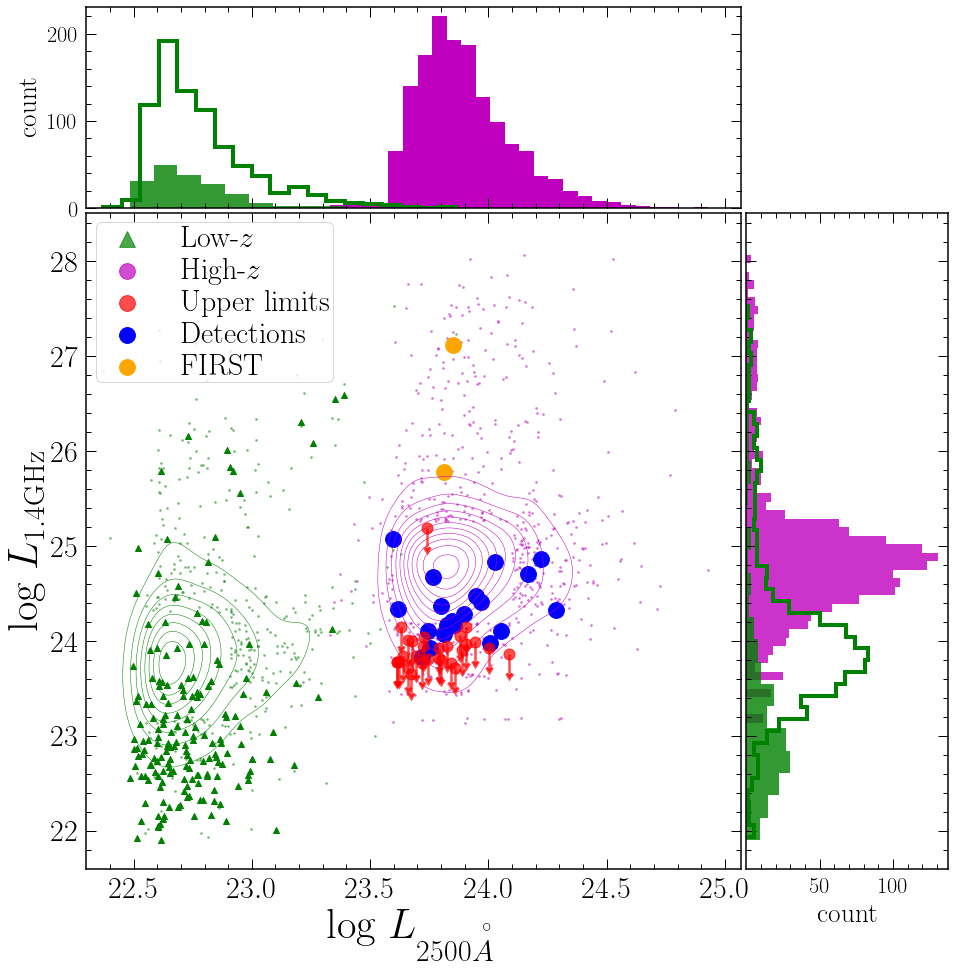

In [44]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(14, 14))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

#Draw a line representing R=1
#Req1 = np.arange(22.2, 25.5, 0.1)
#ax_scatter.plot(Req1, Req1, ":k")

#Use these lines for the legend
ax_scatter.scatter(5000, 5000, s=250, marker="^", color="g", alpha=0.7, label="Low-$z$")
ax_scatter.scatter(5000, 5000, s=250, color="m", alpha=0.7, label="High-$z$")                  
#GTR data
ax_scatter.scatter(5000, 5000, s=250, color="red", alpha=0.7, label="Upper limits")
ax_scatter.scatter(5000, 5000, s=250, color="blue", label="Detections")
ax_scatter.scatter(5000, 5000, s=250, color="orange", label="FIRST")

#Plot Kimball/Kellermann data
ax_scatter.contour(X, Y, Z, levels=10, linewidths=0.5, colors='g')
ax_scatter.scatter(L2500_kell, L14_kell, marker="^", color="g")
ax_scatter.scatter(cLopt[((cLopt>22.9)|((cLrad>24.3)|(cLrad<23.2)))], 
                   cLrad[((cLopt>22.9)|((cLrad>24.3)|(cLrad<23.2)))], s=3, 
                   color="g", alpha=0.4)

#Plot all positive NVSS values
ax_scatter.scatter(L2500_hiz[((L14_hiz>0.)&(((L14_hiz>25.25)|(L14_hiz<24.2))|((L2500_hiz>24.1)|(L2500_hiz<23.6))))], 
                   L14_hiz[((L14_hiz>0.)&(((L14_hiz>25.25)|(L14_hiz<24.2))|((L2500_hiz>24.1)|(L2500_hiz<23.6))))], 
                   color="m", s=3, alpha=0.4)
ax_scatter.contour(X2, Y2, Z2, levels=16, linewidths=0.5, colors='m')

#Plot GTR data
ax_scatter.errorbar(logL2500[D==0], logGTR[D==0], yerr=0.2, uplims=True, fmt="o", 
                    color="red", alpha=0.7, markersize=11, elinewidth=2.5, capthick=3)
ax_scatter.scatter(logL2500[D==1], logGTR[D==1], color="blue",s=250)
ax_scatter.scatter(logL2500[D==2], logGTR[D==2], color="orange",s=250)

#Plot x axis distribution
ax_histx.hist(L2500_hiz[L14_hiz>0.],bins="scott",align='mid',color="m")
ax_histx.hist(L2500_kell,bins="scott",align='mid',color="g", alpha=0.8)
ax_histx.hist(cLopt,bins="scott",align="mid",color="g",histtype="step",linewidth=4)
ax_histx.set_ylabel('count', fontsize=27.5)
ax_histx.tick_params(axis='both', which='major', labelsize=22.5)

#Plot y axis distribution
ax_histy.hist(L14_hiz[L14_hiz>0.],bins=55,orientation='horizontal',align='mid',color="m", alpha=0.8)
ax_histy.hist(L14_kell,bins=20,orientation='horizontal',align='mid',color="g", alpha=0.8)
ax_histy.hist(cLrad,bins=45,orientation='horizontal',align='mid',color='g',histtype="step",linewidth=4)
ax_histy.set_xlabel('count', fontsize=27.5)
ax_histy.tick_params(axis='both', which='major', labelsize=22.5)
ax_histy.set_xticks([50,100])

ax_scatter.set_xlabel("log $L_{2500\AA}$", fontsize=42.5)
ax_scatter.set_ylabel("log $L_\mathrm{1.4GHz}$", fontsize=42.5)
ax_scatter.legend(bbox_to_anchor=(0.4,0.72), frameon=True, prop={"size": 30.0},
                  borderpad=0.05, labelspacing=0.1)
#ax_scatter.legend(bbox_to_anchor=(0.65,1.29), frameon=False, prop={"size": 27.0})
ax_scatter.set_xlim(22.30, 25.07)
ax_scatter.set_ylim(21.60, 28.50)
ax_scatter.tick_params(axis='both', which='major', labelsize=30)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

#R=1
Lo=np.linspace(cLopt.min(),L2500_hiz.max(),5)
Lr=np.linspace(cLrad.min(),L14_hiz.max(),5)
ax_scatter.plot()

plt.tight_layout()
plt.savefig("PaperPlots/radioVSopt_whistos.pdf")
plt.show()

In [45]:
df = pd.read_csv("../../RQQSOs_AmyKimball/condon_sample_02z045_NVSS.txt", sep=" ")
(np.array(df)[:,-14]>0.).sum()

965

^ The NVSS objects shown are only those with $z<1.75$.  I wanted to make the green objects all of the 1313 $0.2<z<0.45$ Condon+13 QSOs, but I couldn't figure out how to do the SDSS selection... the paper only provides the list of NVSS-*detected* objects, which is only N=163, so might as well use the Kimball+2011 data (N=178) as it also contains RQ sources

10/31/2020: Okay, now the Condon objects are in the plot, but only 807/965 of the ones with positive flux densities.  The NVSS text file that Amy sent me has names that don't quite match those in DR7 (only ~370/1313 match exactly); I added errors bars to the RA/DEC and managed 1087/1313, which led to the 807 in the plot above, but couldn't quite recover the full 1313.  Maybe the NVSS list of objects is slightly messed up and we need the original list of SDSS objects.  We probably should try to find them even though it won't make a huge difference in the above plot.

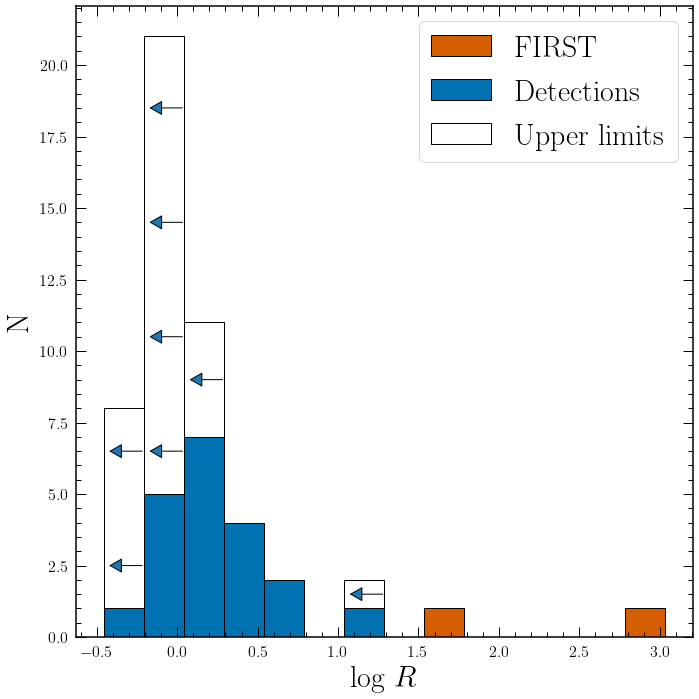

In [46]:
Rbins = np.linspace(min(logR), max(logR), 15)

fig = plt.figure(figsize=(10,10))

plt.hist([logR[D==2], logR[D==1], logR[D==0]], histtype="barstacked", bins=Rbins, 
         edgecolor="k", color=["#d55e00", "#0072b2", "w"], 
         label=["FIRST","Detections","Upper limits"])

#Upper limit symbols
plt.annotate('', xy=(-0.205, 2.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))
plt.annotate('', xy=(-0.205, 6.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))

plt.annotate('', xy=(0.045, 6.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))
plt.annotate('', xy=(0.045, 10.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))
plt.annotate('', xy=(0.045, 14.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))
plt.annotate('', xy=(0.045, 18.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))

plt.annotate('', xy=(0.295, 9.0), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))

plt.annotate('', xy=(1.29, 1.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))

plt.xlabel("log $R$", fontsize=30)
plt.ylabel("N", fontsize=30)
plt.legend(loc="upper right", prop={"size":30})
plt.tight_layout()
plt.savefig("PaperPlots/logR_distribution.pdf")
plt.show()

Hmm, maybe it makes more sense to make this an inset of the flux distribution figure.

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


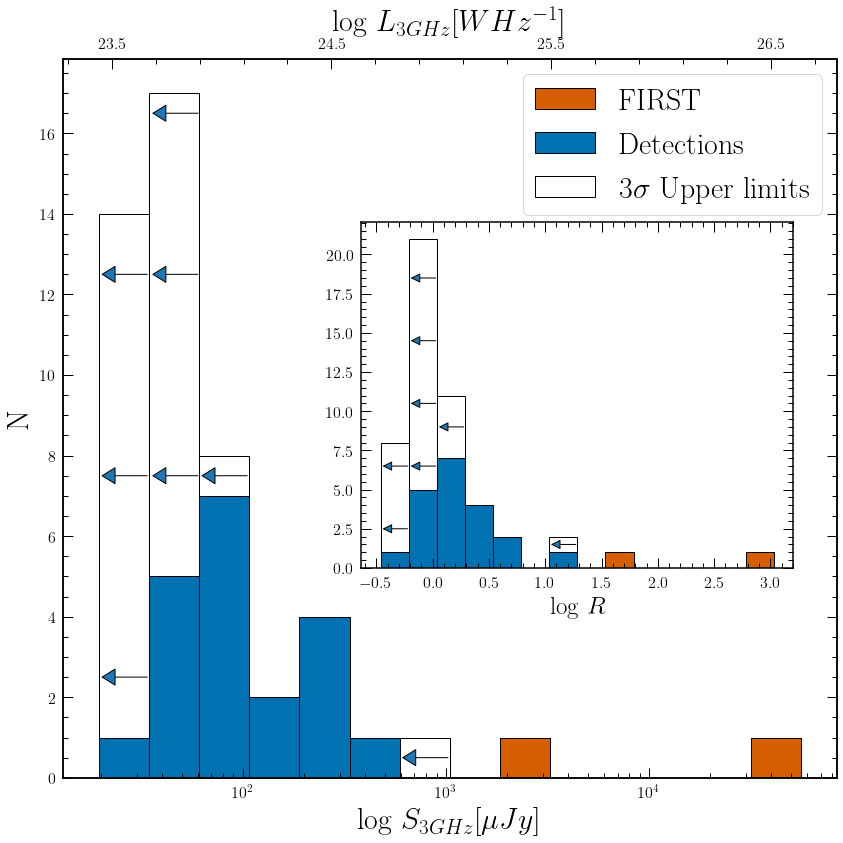

In [47]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111)

Lbins = np.linspace(min(L3), max(L3), 15)
Sbins = np.logspace(np.log10(min(S3)), np.log10(max(S3)), 15)


ax1.hist([S3[D==2], S3[D==1], S3[D==0]], histtype="barstacked", color=["#d55e00", "#0072b2", "w"],
          edgecolor="k", bins=Sbins, label=["FIRST", "Detections", "3$\sigma$ Upper limits"])


#Upper limit symbols
ax1.annotate('', xy=(10**1.54, 2.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.54, 7.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.54, 12.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**1.79, 7.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.79, 12.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.79, 16.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**2.032, 7.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**3.02, 0.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))

#ax1.set_xscale("log")
ax1.set_xlabel("log $S_{3GHz}[\\mu Jy$]", fontsize=30)
ax1.set_ylabel("N", fontsize=30)
ax1.legend(loc="best", prop={"size": 30})
ax1.set_xscale("log")

#Manually add luminosity axis
ax2 = ax1.twiny()
ax2.set_xlim(23.28,26.8)
ax2.set_xticks([23.5, 24.5, 25.5, 26.5])
ax2.set_xlabel("log $L_{3GHz} [W Hz^{-1}]$", fontsize=30)


# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.43, 0.33, 0.50, 0.40]
ax3 = fig.add_axes([left, bottom, width, height])

ax3.hist([logR[D==2], logR[D==1], logR[D==0]], histtype="barstacked", bins=Rbins, 
         edgecolor="k", color=["#d55e00", "#0072b2", "w"], 
         label=["FIRST","Detections","Upper limits"])

#Upper limit symbols
ax3.annotate('', xy=(-0.205, 2.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))
ax3.annotate('', xy=(-0.205, 6.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))

ax3.annotate('', xy=(0.045, 6.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))
ax3.annotate('', xy=(0.045, 10.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))
ax3.annotate('', xy=(0.045, 14.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))
ax3.annotate('', xy=(0.045, 18.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))

ax3.annotate('', xy=(0.295, 9.0), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))

ax3.annotate('', xy=(1.29, 1.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))

ax3.set_xlabel("log $R$", fontsize=25)
#ax3.set_ylabel("N", fontsize=20)
#ax3.legend(loc="upper right")
plt.tight_layout()
plt.savefig("PaperPlots/flux_distribution_wlum_logRinset.pdf")
plt.show()

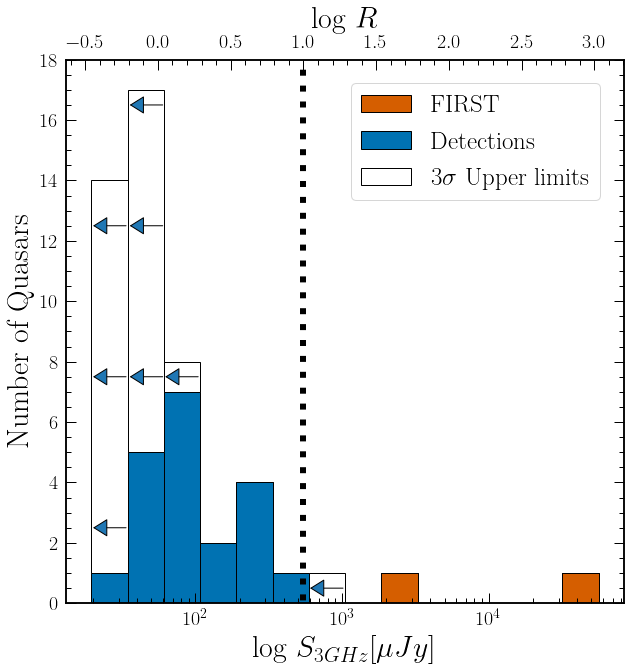

In [48]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

Lbins = np.linspace(min(L3), max(L3), 15)
Sbins = np.logspace(np.log10(min(S3)), np.log10(max(S3)), 15)


ax1.hist([S3[D==2], S3[D==1], S3[D==0]], histtype="barstacked", color=["#d55e00", "#0072b2", "w"],
          edgecolor="k", bins=Sbins, label=["FIRST", "Detections", "3$\sigma$ Upper limits"])


#Upper limit symbols
ax1.annotate('', xy=(10**1.54, 2.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.54, 7.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.54, 12.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**1.79, 7.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.79, 12.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.79, 16.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**2.032, 7.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**3.02, 0.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))

ax1.plot([10.**2.7365, 10.**2.7365], [-2, 20], ":k", linewidth=6.0)

ax1.set_ylim(0,18.0)
#ax1.set_xscale("log")
ax1.set_xlabel("log $S_{3GHz}[\\mu Jy$]", fontsize=30)
ax1.set_ylabel("Number of Quasars", fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.legend(bbox_to_anchor=(0.98,0.98), prop={"size": 25})
ax1.set_xscale("log")


#Manually add log R axis
ax2 = ax1.twiny()
ax2.set_xlim(ax3.get_xlim())
ax2.set_xticks([-0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
ax2.set_xlabel("log $R$", fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.savefig("PaperPlots/flux_distribution_wlogR.pdf")
plt.show()